In [1]:
# Import libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample, shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Extract data
data = pd.read_csv(f'../../ETL/Load/stockData.csv', header=(0), sep=';')

In [3]:
# Replace inf values by very large number
data.replace(np.inf, 1e20, inplace=True)

In [4]:
# Separate train and test data
# Train: first 8 years
# Test: last 2 years

data['DATE'] = pd.to_datetime(data['DATE'])
data_train = data[data['DATE'].dt.year <= 2021]
data_test = data[data['DATE'].dt.year > 2021]

In [5]:
# Change data to numpy
data_train = data_train.to_numpy()
data_test = data_test.to_numpy()

# Get number of rows and columns
ncol = data.shape[1]

# Get arrays for features and class
y_train = data_train[:,-1]
X_train = data_train[:,2:ncol-1]
y_test = data_test[:,-1]
X_test = data_test[:,2:ncol-1]

In [6]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [7]:
# Convert y to integer
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [8]:
# Upsample 1 Class
# Convert X_train and y_train to DataFrame and Series, respectively
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

# Split the dataset by class
X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]

y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

# Resample minority class to match the majority class size
X_train_minority_upsampled = resample(X_train_minority, 
                                      replace=True,     
                                      n_samples=len(X_train_majority),  
                                      random_state=42)

y_train_minority_upsampled = resample(y_train_minority, 
                                      replace=True,     
                                      n_samples=len(y_train_majority),  
                                      random_state=42)

# Combine majority class and upsampled minority class
X_train_balanced = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_balanced = pd.concat([y_train_majority, y_train_minority_upsampled])

# Shuffle the data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

In [9]:
# Train Logistic Regression Model
model = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
model.fit(X_train_balanced, y_train_balanced)

# Scale test data
X_test = scaler.transform(X_test)

# Predict y with test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)



Accuracy: 0.503420523138833
Precision: 0.04019688269073011
Recall (Sensitivity): 0.4336283185840708
F1-Score: 0.07357357357357357


In [10]:
# Information on the model
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Classes:", model.classes_)
print("Iterations to Converge:", model.n_iter_)

Coefficients: [[-8.20631623e-02 -1.82541103e-01 -1.28870092e-01  6.78765841e-02
   2.22076873e-01 -6.80502788e-01 -3.42427770e-01  2.65287729e-01
   3.89101708e-02 -3.26278693e-04  7.06461225e-02]]
Intercept: [-0.06218089]
Classes: [0 1]
Iterations to Converge: [23]


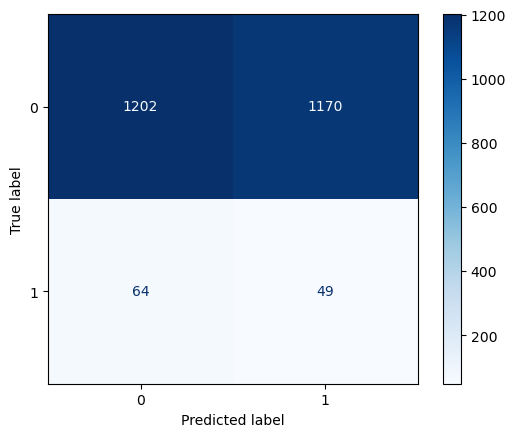

In [11]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()